In [7]:
#! /usr/bin/env python

import os
import argparse
import json
import cv2
from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from keras.models import load_model
from tqdm import tqdm
import numpy as np

def _main_(args):
    config_path  = args.conf
    input_path   = args.input
    output_path  = args.output

    with open(config_path) as config_buffer:    
        config = json.load(config_buffer)

    makedirs(output_path)

    ###############################
    #   Set some parameter
    ###############################       
    net_h, net_w = 416, 416 # a multiple of 32, the smaller the faster
    obj_thresh, nms_thresh = 0.5, 0.45

    ###############################
    #   Load the model
    ###############################
    os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']
    infer_model = load_model(config['train']['saved_weights_name'])

    ###############################
    #   Predict bounding boxes 
    ###############################
    if 'webcam' in input_path: # do detection on the first webcam
        video_reader = cv2.VideoCapture(0)

        # the main loop
        batch_size  = 1
        images      = []
        while True:
            ret_val, image = video_reader.read()
            if ret_val == True: images += [image]

            if (len(images)==batch_size) or (ret_val==False and len(images)>0):
                batch_boxes = get_yolo_boxes(infer_model, images, net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)

                for i in range(len(images)):
                    draw_boxes(images[i], batch_boxes[i], config['model']['labels'], obj_thresh) 
                    cv2.imshow('video with bboxes', images[i])
                images = []
            if cv2.waitKey(1) == 27: 
                break  # esc to quit
        cv2.destroyAllWindows()        
    elif input_path[-4:] == '.mp4': # do detection on a video  
        video_out = output_path + input_path.split('/')[-1]
        video_reader = cv2.VideoCapture(input_path)

        nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

        video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'MPEG'), 
                               50.0, 
                               (frame_w, frame_h))
        # the main loop
        batch_size  = 1
        images      = []
        start_point = 0 #%
        show_window = False
        for i in tqdm(range(nb_frames)):
            _, image = video_reader.read()

            if (float(i+1)/nb_frames) > start_point/100.:
                images += [image]

                if (i%batch_size == 0) or (i == (nb_frames-1) and len(images) > 0):
                    # predict the bounding boxes
                    batch_boxes = get_yolo_boxes(infer_model, images, net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)

                    for i in range(len(images)):
                        # draw bounding boxes on the image using labels
                        draw_boxes(images[i], batch_boxes[i], config['model']['labels'], obj_thresh)   

                        # show the video with detection bounding boxes          
                        if show_window: cv2.imshow('video with bboxes', images[i])  

                        # write result to the output video
                        video_writer.write(images[i]) 
                    images = []
                if show_window and cv2.waitKey(1) == 27: break  # esc to quit

        if show_window: cv2.destroyAllWindows()
        video_reader.release()
        video_writer.release()       
    else: # do detection on an image or a set of images
        image_paths = []

        if os.path.isdir(input_path): 
            for inp_file in os.listdir(input_path):
                image_paths += [input_path + inp_file]
        else:
            image_paths += [input_path]

        image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]

        # the main loop
        for image_path in image_paths:
            image = cv2.imread(image_path)
            print(image_path)

            # predict the bounding boxes
            boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, config['model']['anchors'], obj_thresh, nms_thresh)[0]

            # draw bounding boxes on the image using labels
            draw_boxes(image, boxes, config['model']['labels'], obj_thresh) 
     
            # write the image with bounding boxes to file
            cv2.imwrite(output_path + image_path.split('/')[-1], np.uint8(image))         

if __name__ == '__main__':
    argparser = argparse.ArgumentParser(description='Predict with a trained yolo model')
    argparser.add_argument('-c', '--conf', help='path to configuration file')
    argparser.add_argument('-i', '--input', help='path to an image, a directory of images, a video, or webcam')    
    argparser.add_argument('-o', '--output', default='output/', help='path to output directory')   
    
    args = argparser.parse_args()
    _main_(args)


Using TensorFlow backend.
usage: ipykernel_launcher.py [-h] [-c CONF] [-i INPUT] [-o OUTPUT]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/13002/jupyter/kernel-ab18f1d8-d56c-4af1-8697-5622126e7120.json


SystemExit: 2

/N/u/imtiazahmad/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
python predict.py -c config.json -i "~/YOLO3_MULTIGPU/keras-yolo3/102nd_1090.jpg"

SyntaxError: invalid syntax (<ipython-input-8-b7c165282a51>, line 1)

In [9]:
cd output

/home/imtiazahmad/YOLO3_MULTIGPU/keras-yolo3/output


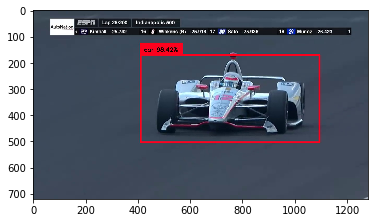

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('102nd_1090.jpg')
imgplot = plt.imshow(img)
plt.show()

In [17]:
#! /usr/bin/env python

import argparse
import os
import numpy as np
import json
from voc import parse_voc_annotation
from yolo import create_yolov3_model
from generator import BatchGenerator
from utils.utils import normalize, evaluate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.models import load_model

def _main_(args):
    config_path = args.conf

    with open(config_path) as config_buffer:    
        config = json.loads(config_buffer.read())

    ###############################
    #   Create the validation generator
    ###############################  
    valid_ints, labels = parse_voc_annotation(
        config['valid']['valid_annot_folder'], 
        config['valid']['valid_image_folder'], 
        config['valid']['cache_name'],
        config['model']['labels']
    )

    labels = labels.keys() if len(config['model']['labels']) == 0 else config['model']['labels']
    labels = sorted(labels)
   
    valid_generator = BatchGenerator(
        instances           = valid_ints, 
        anchors             = config['model']['anchors'],   
        labels              = labels,        
        downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
        max_box_per_image   = 0,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],   
        shuffle             = True, 
        jitter              = 0.0, 
        norm                = normalize
    )

    ###############################
    #   Load the model and do evaluation
    ###############################
    os.environ['CUDA_VISIBLE_DEVICES'] = config['train']['gpus']

    infer_model = load_model(config['train']['saved_weights_name'])

    # compute mAP for all the classes
    average_precisions = evaluate(infer_model, valid_generator)

    # print the score
    for label, average_precision in average_precisions.items():
        print(labels[label] + ': {:.4f}'.format(average_precision))
    print('mAP: {:.4f}'.format(sum(average_precisions.values()) / len(average_precisions)))           

if __name__ == '__main__':
    argparser = argparse.ArgumentParser(description='Evaluate YOLO_v3 model on any dataset')
    argparser.add_argument('-c', '--conf', help='path to configuration file')    
    
    args = argparser.parse_args()
    _main_(args)


usage: ipykernel_launcher.py [-h] [-c CONF]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/13002/jupyter/kernel-ab18f1d8-d56c-4af1-8697-5622126e7120.json


SystemExit: 2

/N/u/imtiazahmad/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [21]:
import tensorflow as tf
import datetime, os


%tensorboard --logdir logs/

UsageError: Line magic function `%tensorboard` not found.


In [23]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [24]:
pip install jupyter-tensorboard

  Stored in directory: /N/u/imtiazahmad/.cache/pip/wheels/12/51/ec/a9ef181e77d44427a00f0c52fd9f1758cad0fe910a34ca8288
Successfully built jupyter-tensorboard
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Load TENSORBOARD
%load_ext tensorboard
# Start TENSORBOARD
%tensorboard --logdir logs